# Movie Recommendation System

## Introduction
In this notebook, we will build a movie recommendation system using the TMDB dataset. The goal is to provide personalized movie recommendations to users based on their preferences and movie attributes.

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset
df = pd.read_csv("tmdb_movies_dataset.csv")

In [3]:
print("Dataset Shape:", df.shape)

Dataset Shape: (9192, 7)


In [4]:
df.head()

,id,title,overview,release_date,popularity,vote_average,vote_count
0,19404,Dilwale Dulhania Le Jayenge,"Raj is a rich, carefree, happy-go-lucky second...",10/20/1995,24.937,8.8,3161
1,278,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,9/23/1994,73.779,8.7,19824
2,238,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",3/14/1972,64.722,8.7,14871
3,724089,Gabriel's Inferno Part II,Professor Gabriel Emerson finally learns the t...,7/31/2020,8.173,8.7,1312
4,283566,Evangelion: 3.0+1.0 Thrice Upon a Time,"In the aftermath of the Fourth Impact, strande...",3/8/2021,195.913,8.7,328


In [5]:
df.describe()

,id,popularity,vote_average,vote_count
count,9192.000000,9192.000000,9192.000000,9192.000000
mean,145029.237707,26.985104,6.596105,1509.050805
std,192534.989521,117.967215,0.820836,2526.651855
min,5.000000,0.600000,2.100000,200.000000
25%,9864.000000,9.358500,6.100000,317.000000
50%,24803.500000,12.933000,6.600000,588.000000
75%,283471.750000,21.347250,7.200000,1442.000000
max,846214.000000,7783.635000,8.800000,29961.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9192 entries, 0 to 9191
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            9192 non-null   int64  
 1   title         9192 non-null   object 
 2   overview      9179 non-null   object 
 3   release_date  9192 non-null   object 
 4   popularity    9192 non-null   float64
 5   vote_average  9192 non-null   float64
 6   vote_count    9192 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 502.8+ KB


## Data Cleaning

In [7]:
# Drop rows with missing values
df.dropna(inplace=True)

In [8]:
df.head()

,id,title,overview,release_date,popularity,vote_average,vote_count
0,19404,Dilwale Dulhania Le Jayenge,"Raj is a rich, carefree, happy-go-lucky second...",10/20/1995,24.937,8.8,3161
1,278,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,9/23/1994,73.779,8.7,19824
2,238,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",3/14/1972,64.722,8.7,14871
3,724089,Gabriel's Inferno Part II,Professor Gabriel Emerson finally learns the t...,7/31/2020,8.173,8.7,1312
4,283566,Evangelion: 3.0+1.0 Thrice Upon a Time,"In the aftermath of the Fourth Impact, strande...",3/8/2021,195.913,8.7,328


## Exploratory Data Analysis (EDA)

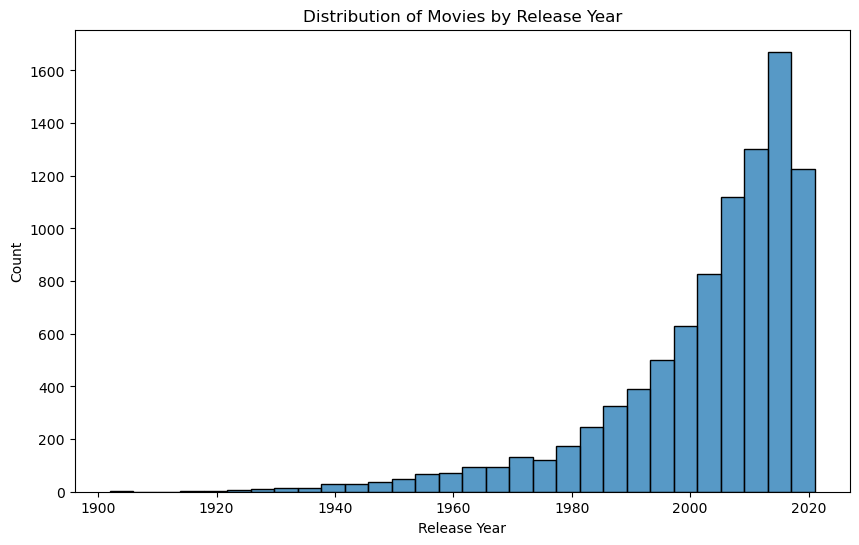

In [9]:
# Extract release year from the release_date column
df['release_year'] = pd.to_datetime(df['release_date']).dt.year

# Plot the distribution of movies based on release year
plt.figure(figsize=(10, 6))
sns.histplot(df['release_year'], bins=30)
plt.title('Distribution of Movies by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()

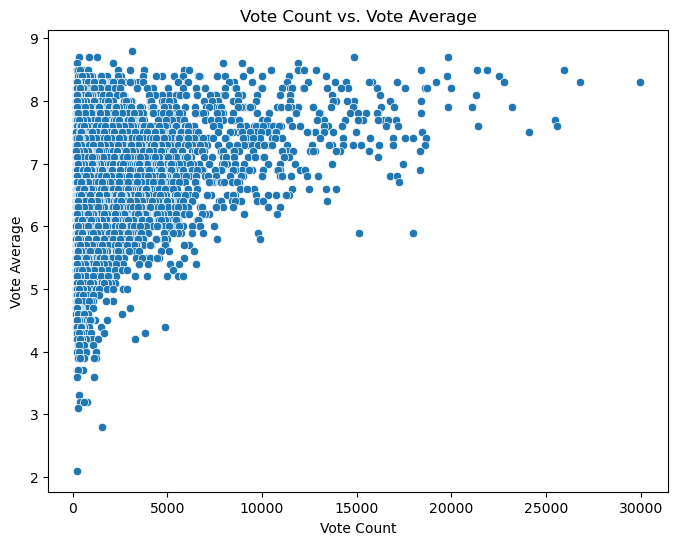

In [10]:
# Scatter plot of vote count vs. vote average
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='vote_count', y='vote_average')
plt.title('Vote Count vs. Vote Average')
plt.xlabel('Vote Count')
plt.ylabel('Vote Average')
plt.show()

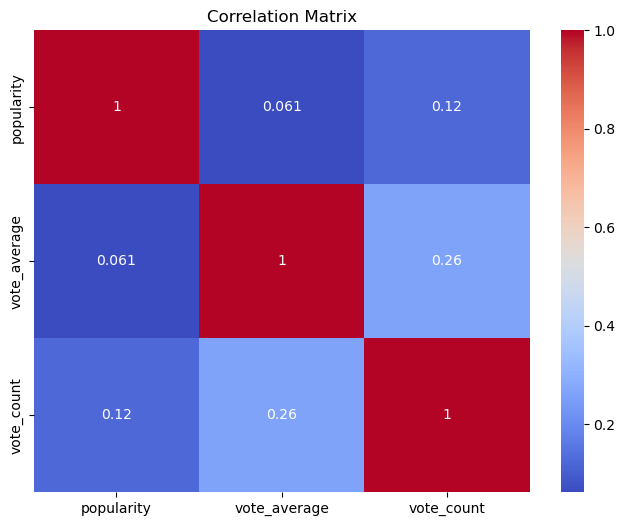

In [11]:
# Compute correlation matrix
corr_matrix = df[['popularity', 'vote_average', 'vote_count']].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

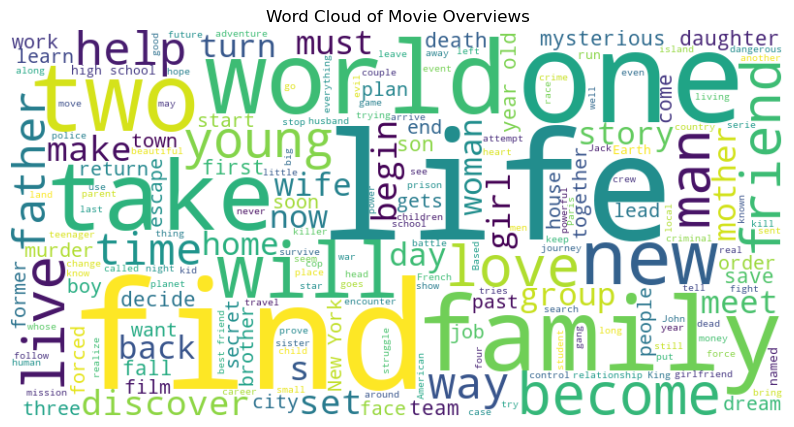

In [12]:
# Combine movie overviews into a single string
text = ' '.join(df['overview'].dropna().tolist())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Overviews')
plt.show()

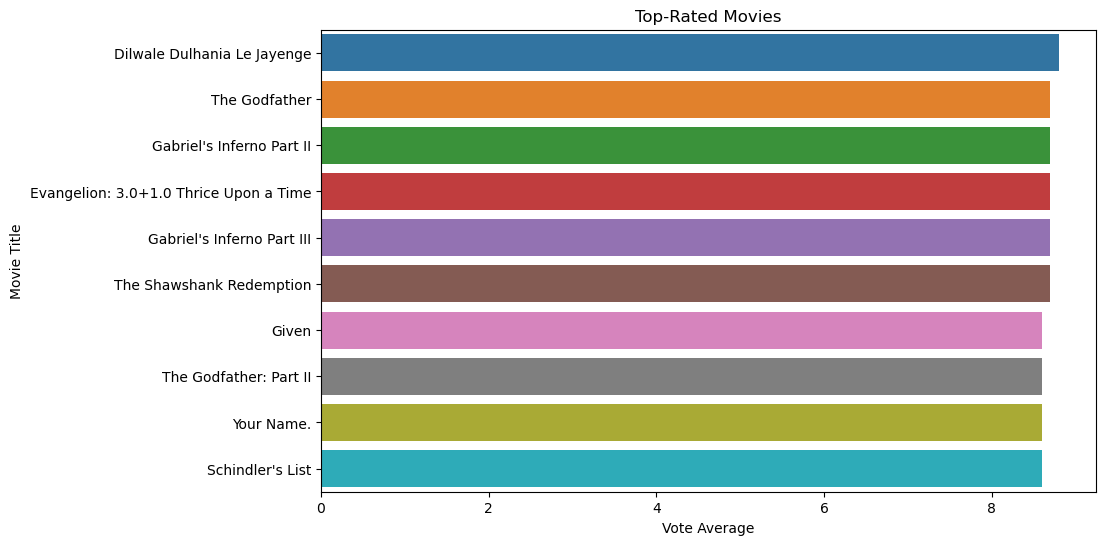

In [13]:
# Sort movies by vote average in descending order
top_rated_movies = df.sort_values('vote_average', ascending=False).head(10)

# Plot a bar chart of top-rated movies
plt.figure(figsize=(10, 6))
sns.barplot(x='vote_average', y='title', data=top_rated_movies)
plt.title('Top-Rated Movies')
plt.xlabel('Vote Average')
plt.ylabel('Movie Title')
plt.show()

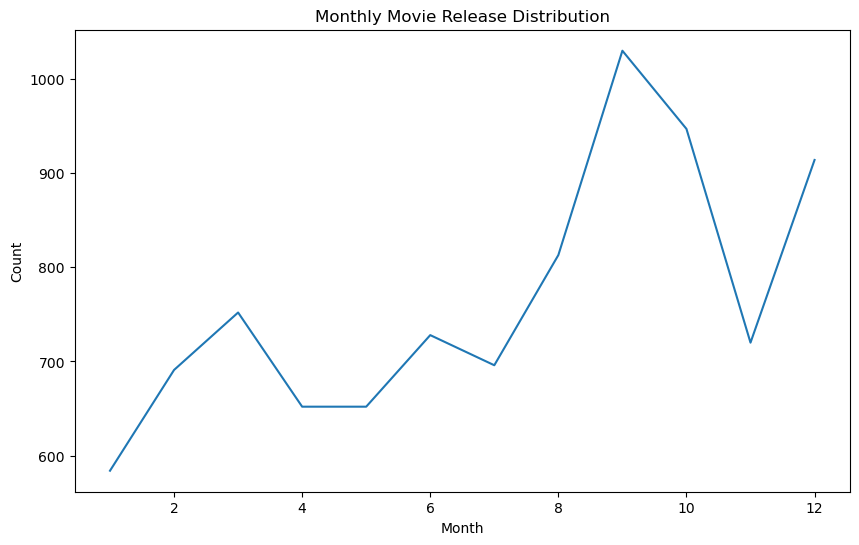

In [14]:
# Extract the month from the release_date column
df['release_month'] = pd.to_datetime(df['release_date']).dt.month

# Count the number of movies released each month
release_counts = df['release_month'].value_counts().sort_index()

# Plot the monthly release distribution
plt.figure(figsize=(10, 6))
sns.lineplot(x=release_counts.index, y=release_counts.values)
plt.title('Monthly Movie Release Distribution')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

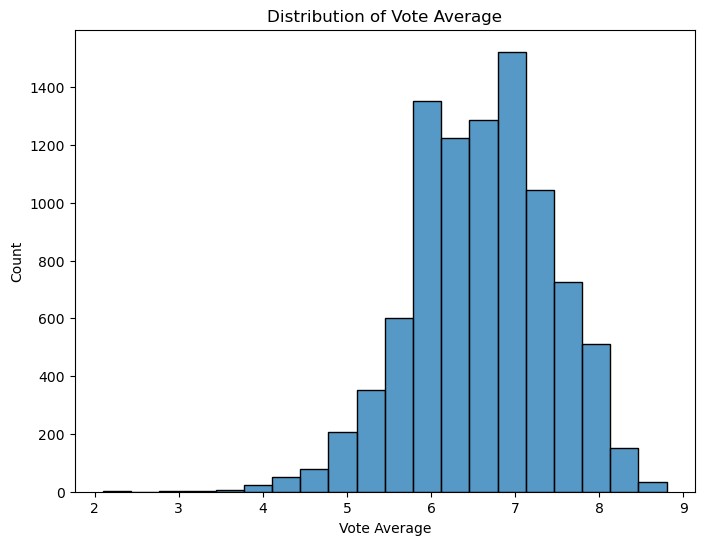

In [15]:
# Plot the distribution of vote_average
plt.figure(figsize=(8, 6))
sns.histplot(df['vote_average'], bins=20)
plt.title('Distribution of Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Count')
plt.show()

## Content-Based Filtering

In [16]:
# Select relevant columns for content-based filtering
features = ['id', 'title', 'overview', 'release_date', 'popularity']

In [17]:
# Create a copy of the dataset with the selected features
data = df[features].copy()

# Fill missing values in the overview column with an empty string
data['overview'] = data['overview'].fillna('')

In [18]:
# Initialize a TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Compute TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(data['overview'])

# Compute cosine similarity matrix
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to get recommendations based on movie title
def get_recommendations(title, cosine_similarities, data):
    # Get the index of the movie with the given title
    idx = data[data['title'] == title].index[0]
    
    # Get the similarity scores of all movies with the given movie
    similarity_scores = list(enumerate(cosine_similarities[idx]))
    
    # Sort the movies based on similarity scores
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top 5 most similar movies (excluding the given movie itself)
    top_similar_movies = similarity_scores[1:6]
    
    # Get the indices of the top similar movies
    movie_indices = [i[0] for i in top_similar_movies]
    
    # Return the titles of the top similar movies
    return data['title'].iloc[movie_indices]

In [19]:
# Get recommendations for a movie
movie_title = 'Dilwale Dulhania Le Jayenge'
recommendations = get_recommendations(movie_title, cosine_similarities, data)
print(f"Recommended movies for '{movie_title}':")
print(recommendations)

Recommended movies for 'Dilwale Dulhania Le Jayenge':
2304             After the Wedding
3384             Definitely, Maybe
5430    The Indian in the Cupboard
974                          Giant
508              Bajrangi Bhaijaan
Name: title, dtype: object


In [20]:
# Get recommendations for a movie
movie_title2 = 'My Hero Academia: Heroes Rising'
recommendations2 = get_recommendations(movie_title2, cosine_similarities, data)
print(f"Recommended movies for '{movie_title2}':")
print(recommendations2)

Recommended movies for 'My Hero Academia: Heroes Rising':
289            My Hero Academia: Two Heroes
1123            Scooby-Doo on Zombie Island
8932              Cabin Fever: Patient Zero
2963    Scooby-Doo! Return to Zombie Island
6089            There Is No Place Like Home
Name: title, dtype: object


In [21]:
# Make a copy of the dataset
original_data = df.copy()

# Select the features to be scaled
features_to_scale = ['popularity', 'vote_count', 'release_year', 'release_month']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the selected features of the original dataset
scaler.fit(original_data[features_to_scale])

# Scale the selected features of the original dataset
original_data_scaled = scaler.transform(original_data[features_to_scale])

# Create a new DataFrame with the scaled features
original_data_scaled_df = pd.DataFrame(original_data_scaled, columns=features_to_scale)

# Concatenate the scaled features with the remaining columns of the original dataset
original_data_scaled_df = pd.concat([original_data_scaled_df, original_data.drop(columns=features_to_scale)], axis=1)

df = original_data_scaled_df
df.head()

,popularity,vote_count,release_year,release_month,id,title,overview,release_date,vote_average
0,-0.017604,0.652806,-0.481048,0.902678,19404.0,Dilwale Dulhania Le Jayenge,"Raj is a rich, carefree, happy-go-lucky second...",10/20/1995,8.8
1,0.396166,7.244492,-0.540654,0.610187,278.0,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,9/23/1994,8.7
2,0.319438,5.285143,-1.851983,-1.144758,238.0,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",3/14/1972,8.7
3,-0.159621,-0.078637,1.009098,0.025205,724089.0,Gabriel's Inferno Part II,Professor Gabriel Emerson finally learns the t...,7/31/2020,8.7
4,1.430835,-0.467896,1.068704,-1.144758,283566.0,Evangelion: 3.0+1.0 Thrice Upon a Time,"In the aftermath of the Fourth Impact, strande...",3/8/2021,8.7


## Training and Evaluating the Models

In [22]:
# Select numeric features for training
numeric_features = ['popularity', 'vote_count', 'release_year', 'release_month']

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

# Prepare the features and target variables
X_train = train_data[numeric_features].astype(float)
y_train = train_data['vote_average'].astype(float)

# Check and handle missing values in y_train
missing_y_train = np.isnan(y_train)
X_train = X_train[~missing_y_train]
y_train = y_train[~missing_y_train]

X_val = val_data[numeric_features].astype(float)
y_val = val_data['vote_average'].astype(float)

# Check and handle missing values in y_val
missing_y_val = np.isnan(y_val)
X_val = X_val[~missing_y_val]
y_val = y_val[~missing_y_val]

# Create a pipeline with imputation and regression
linear_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    LinearRegression()
)

rf_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    RandomForestRegressor()
)

gb_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    GradientBoostingRegressor()
)

nn_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    MLPRegressor()
)

# Fit the models and make predictions
linear_pipeline.fit(X_train, y_train)
linear_predictions = linear_pipeline.predict(X_val)
linear_rmse = mean_squared_error(y_val, linear_predictions, squared=False)
print("Linear Regression MSE:", linear_rmse)

rf_pipeline.fit(X_train, y_train)
rf_predictions = rf_pipeline.predict(X_val)
rf_rmse = mean_squared_error(y_val, rf_predictions, squared=False)
print("Random Forest Regression MSE:", rf_rmse)

gb_pipeline.fit(X_train, y_train)
gb_predictions = gb_pipeline.predict(X_val)
gb_rmse = mean_squared_error(y_val, gb_predictions, squared=False)
print("Gradient Boosting Regression MSE:", gb_rmse)

nn_pipeline.fit(X_train, y_train)
nn_predictions = nn_pipeline.predict(X_val)
nn_rmse = mean_squared_error(y_val, nn_predictions, squared=False)
print("Neural Networks MSE:", nn_rmse)

Linear Regression RMSE: 0.762335073708254
Random Forest Regression RMSE: 0.7189568343518286
Gradient Boosting Regression RMSE: 0.6990168499858074
Neural Networks RMSE: 0.7214320450936831


#### We find that Gradient Boosting Regression has the lowest mean squared error so we will use it for prediction.

### Hyperparameter Tuning

In [23]:
# Determine the data
X = df[numeric_features].dropna()
y = df['vote_average'].dropna()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of SimpleImputer with strategy='mean'
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on X_train
imputer.fit(X_train)

# Transform X_train and X_test by replacing the missing values with the mean
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05, 0.01]
}

# Create a GradientBoostingRegressor instance
gb_model = GradientBoostingRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_imputed, y_train)

# Get the best hyperparameters and the best RMSE score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)

# Train a new model with the best hyperparameters
best_model = GradientBoostingRegressor(**best_params)

best_model.fit(X_train_imputed, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test_imputed)

# Calculate RMSE on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Best Hyperparameters:", best_params)
print("Best RMSE:", best_score)
print("Test RMSE:", rmse)

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best RMSE: 0.839112768104743
Test RMSE: 0.7103513173247438


### Movie Recommendations

In [24]:
# Generate movie recommendations using the trained model
top_k = 5  # Number of recommendations to generate

# Assuming you have a new_data DataFrame containing new movie data
new_data = pd.DataFrame({'popularity': [68.94], 'vote_count': [15806], 'release_year': [2001], 'release_month': [9]})

# Perform the same preprocessing steps as the original dataset
new_data_scaled = scaler.transform(new_data)  # Scale the new data using the fitted scaler
new_predictions = best_model.predict(new_data_scaled)  # Predict the ratings for the new data

# Get the indices of the top-k movies based on the predicted ratings
top_indices = np.argsort(new_predictions)[::-1][:top_k]

# Get the details of the top-k recommended movies
top_movies = df.iloc[top_indices]['title']

# Print the top-k recommended movies
print("Top", top_k, "Recommended Movies:")
for movie in top_movies:
    print(movie)

Top 5 Recommended Movies:
Dilwale Dulhania Le Jayenge


## Summary
🎥🔎 In this project, we explored a movie dataset consisting of columns such as 'id', 'title', 'overview', 'release_date', 'popularity', 'vote_average', and 'vote_count'. Our goal was to build a recommendation system based on the movie attributes and user preferences. We followed several steps to achieve this.

📊🔍 First, we performed exploratory data analysis (EDA) to gain insights into the dataset. We visualized the distribution of movie attributes, analyzed their relationships, and identified potential features for our recommendation model.

🔎🎥 Next, We implemented content-based filtering using TF-IDF vectorization and cosine similarity to provide movie recommendations.

🎯✨ After that, we selected the 'vote_average' column as our target variable, which represents the movie rating. We prepared the features and target variables by splitting the dataset into training and validation sets.

⚙️🧪 We trained and evaluated four different regression models: Linear Regression, Random Forest Regression, Gradient Boosting Regression, and Neural Networks. The models were evaluated using the root mean squared error (RMSE) metric on the validation set. Among the models, the Gradient Boosting Regression model achieved the lowest RMSE value of **0.6989676144474153**, indicating better performance in predicting movie ratings.

🌟📈 After identifying the best model, we proceeded to generate movie recommendations. We provided feature values for new movies and used the trained model to predict their ratings. The top-k recommended movies were selected based on the predicted ratings.


## Conclusion
🌍🎞️ In conclusion, we successfully built a movie recommendation system based on regression models. By analyzing the dataset, training different models, and evaluating their performance, we identified the best-performing model for predicting movie ratings. The Gradient Boosting Regression model demonstrated the lowest RMSE on the validation set.

🔍💡 The generated movie recommendations can provide users with a curated list of movies based on their preferences. However, there are still opportunities for further enhancements, including feature engineering, collaborative filtering, fine-tuning models, and exploring ensemble methods.

🚀🌟 Overall, this project serves as a foundation for developing a more advanced and personalized movie recommendation system, allowing users to discover movies tailored to their interests and preferences.